In [1]:
require 'numo/narray'
require 'numo/gnuplot'

true

In [2]:
require_relative 'dataset/mnist'

true

In [3]:
x_train, t_train, x_test, t_test = MNIST.load_mnist(
    flatten: true, normalize: false)


[<MNISTImages @length=60000, @normalize=false, @flatten=true>, <MNISTLabels @length=60000, @one_hot=false>, <MNISTImages @length=10000, @normalize=false, @flatten=true>, <MNISTLabels @length=10000, @one_hot=false>]

In [4]:
x_train.shape

[60000, 784]

In [5]:
t_train.shape

[60000]

In [6]:
img = x_train[0]
label = t_train[0]

5

In [7]:
img.shape

[784]

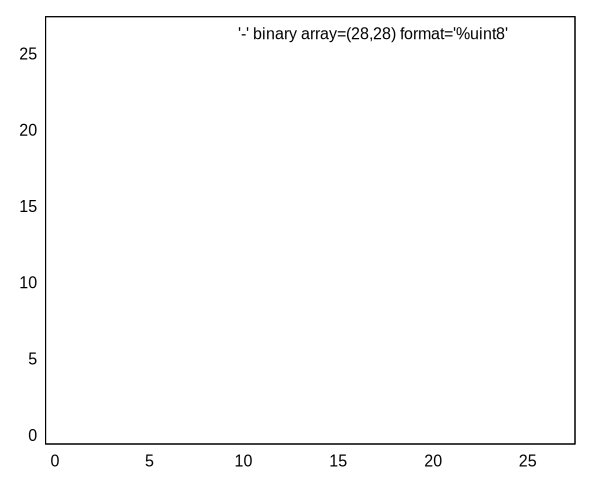

In [8]:
Numo::noteplot do
  # set :key
  set xrange: -0.5...27.5
  set yrange: -0.5...27.5
  set :tic, :scale, 0
  unset :colorbox
  unset :cbtics
  set cbrange: 0..255
  set :palette, "gray"
  set :view, "map" # <- 利かない;;
  plot img.reshape(28, 28).reverse(0), with: "image"
end

In [9]:
def get_data()
  x_train, t_train, x_test, t_test = MNIST::load_mnist(
        normalize: true, flatten: true, one_hot_label: false)
  return x_test, t_test
end

:get_data

In [10]:
x, t = get_data

[<MNISTImages @length=10000, @normalize=true, @flatten=true>, <MNISTLabels @length=10000, @one_hot=false>]

In [11]:
def init_network()
  require_relative 'dataset/load_npy'
  
  {
    "W1" => load_npy("dataset/W1.npy"),
    "b1" => load_npy("dataset/b1.npy"),
    "W2" => load_npy("dataset/W2.npy"),
    "b2" => load_npy("dataset/b2.npy"),
    "W3" => load_npy("dataset/W3.npy"),
    "b3" => load_npy("dataset/b3.npy")
  }
end

:init_network

In [12]:
# シグモイド関数
def sigmoid(x)
  1 / (1 + Numo::NMath.exp(-x)) # Numo::DFloat を返す
end

:sigmoid

In [13]:
# ソフトマックス関数
def softmax(a)
  c = a.max
  exp_a = Numo::NMath.exp(a - c)
  sum_exp_a = exp_a.sum
  return exp_a / sum_exp_a
end

:softmax

In [14]:
def predict(network, x)
  w1, w2, w3 = network["W1"], network["W2"], network["W3"]
  b1, b2, b3 = network["b1"], network["b2"], network["b3"]

  a1 = x.dot(w1) + b1
  z1 = sigmoid(a1)
  a2 = z1.dot(w2) + b2
  z2 = sigmoid(a2)
  a3 = z2.dot(w3) + b3
  y = softmax(a3)

  return y
end

:predict

In [15]:
network = init_network()

{"W1"=>Numo::SFloat(view)#shape=[784,50]
[[-0.00741249, -0.00790439, -0.013075, 0.0185257, -0.00153461, ...], 
 [-0.0102975, -0.0161665, -0.0122838, -0.0179263, 0.00339878, -0.0707078, ...], 
 [-0.0130918, -0.00244747, -0.0177224, -0.0242403, -0.0220408, ...], 
 [-0.0100084, 0.0195861, -0.00561698, 0.0383074, -0.0525067, -0.0235683, ...], 
 [0.0220735, 0.00640837, -0.0283758, -0.0206995, -0.0271802, 0.00562039, ...], 
 [0.0342826, 0.0356078, 0.0200793, 0.018984, 0.0210607, -0.0258285, ...], 
 [0.0181678, 0.0759545, 0.0803725, 0.0126271, 0.0308478, 0.0182223, ...], 
 [-0.0101596, -0.0128061, 0.0148865, 0.0142262, -0.0173277, 0.00898263, ...], 
 [-0.0256382, -0.0372087, -0.0188893, 0.0143945, -0.0177627, 0.00180663, ...], 
 [0.0306505, -0.0347321, -0.0334835, -0.0294925, 0.0147203, -0.00265436, ...], 
 [-0.000140208, -0.052682, -0.0868047, 0.0210401, -0.0335705, 0.0398818, ...], 
 [0.0378605, 0.00899352, -0.0673496, -0.0215917, 0.0231716, 0.0377583, ...], 
 [-0.00906321, 0.0310108, -0.01

In [16]:
def max_index(a)
  idx = 0
  val = a[0]
  a.each_with_index do |v, i|
    if v > val
      val = v
      idx = i
    end
  end
  idx
end

:max_index

In [17]:
accuracy_cnt = 0

x.each_with_index do |xi, i|
  y = predict(network, xi)
  # p = y.max_index # なぜか kernel が死んで落ちる(>_<)ので
  p = max_index(y)
  if p == t[i]
    accuracy_cnt += 1
  end
end

Float(accuracy_cnt) / x.length

0.9352

## バッチ処理（ミニバッチ）

In [18]:
batch_size = 100

100

In [19]:
# ソフトマックス関数（再定義）
def softmax(a)
  if a.is_a?(Numo::NArray) && a.ndim > 1
    return Numo::NArray[*a.shape[0].times.map{|i|softmax(a[i,true])}]
  end
  c = a.max
  exp_a = Numo::NMath.exp(a - c)
  sum_exp_a = exp_a.sum
  return exp_a / sum_exp_a
end

:softmax

In [20]:
accuracy_cnt = 0

0.step(x.length-1, batch_size) do |i|
  x_batch = x[i...i+batch_size]
  y_batch = predict(network, x_batch)
  # ps = y_batch.max_index(1) # ←挙動おかしい
  ps = Numo::NArray[*y_batch.shape[0].times.map { |i| max_index(y_batch[i,true]) }]
  accuracy_cnt += ps.eq(t[i...i+batch_size]).count
end

Float(accuracy_cnt) / x.length

0.9352